## 6.4 Rerank using LGBM Ranker

We will rerank the 30 candidates for each session using the LGBM Ranker, and select the top 20. This is first fitted on the train set and then predicted for the test set. We will do so for Orders only.

We will explore using polars here instead of GPU and Rapids. For explanation of polars, see Part 6.3.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install polars
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm.sklearn import LGBMRanker

In [ ]:
train_candidates_features = pl.read_parquet('/content/drive/MyDrive/0.capstone/covisit_prepare/reranker_candidates_features_train_5.parquet')
test_candidates_features = pl.read_parquet('/content/drive/MyDrive/0.capstone/covisit_prepare/reranker_candidates_features_test_5.parquet')

validation_data_b = pl.read_parquet('/content/drive/MyDrive/0.capstone/train_val/test_labels.parquet')

test = pl.read_parquet('/content/drive/MyDrive/0.capstone/test.parquet')

**Preprocessing**

In [ ]:
type2id = {"clicks": 0, "carts": 1, "orders": 2}

In [ ]:
validation_data_b = validation_data_b.explode('ground_truth').with_columns([
    pl.col('ground_truth').alias('aid'),
    pl.col('type').apply(lambda x: type2id[x])
])[['session', 'type', 'aid']]

In [ ]:
validation_data_b = validation_data_b.with_columns([
    pl.col('session').cast(pl.datatypes.Int32),
    pl.col('type').cast(pl.datatypes.UInt8),
    pl.col('aid').cast(pl.datatypes.Int32)
])

In [ ]:
# Indicate if ground truth
validation_data_b = validation_data_b.with_columns(pl.lit(1).alias('ground_truth'))

In [ ]:
# Filter for orders only
validation_data_b_orders = validation_data_b.filter(pl.col("type") == 2)

In [ ]:
# Map into validation 
train = train_candidates_features.join(validation_data_b_orders, how='left', on=['session', 'aid']).with_columns(pl.col('ground_truth').fill_null(0))
train.head()

session,aid,buy_rank,session_total_interactions,session_unique_aids,session_length,order_aid_unique_sessions,order_aid_total_interactions,cart_aid_unique_sessions,cart_aid_total_interactions,pair_count,pair_count_2,order_num_recurring_aids,cart_num_recurring_aids,last_cart,last_click,cart_order_interaction_ratio,type,ground_truth
i32,i32,f64,i16,i16,f32,i32,i32,i32,i32,u32,u32,i16,i16,u8,i64,f64,u8,i32
11098528,11830,1.0,1,1,0.0,1195,1377,3294,4438,30,30,null,null,null,null,3.222948,2,1
11098528,1732105,0.5,1,1,0.0,565,654,1597,2268,30,30,null,null,null,null,3.46789,null,0
11098528,588923,0.333333,1,1,0.0,687,795,1671,2114,30,30,null,null,null,1,2.659119,null,0
11098528,884502,0.25,1,1,0.0,1032,1183,2352,3003,30,30,null,null,null,null,2.538462,null,0
11098528,876129,0.2,1,1,0.0,840,944,1816,2211,30,30,null,null,null,null,2.342161,null,0


In [ ]:
# train.write_parquet('/content/drive/MyDrive/0.capstone/deploy/train_deploy.parquet', compression="snappy")

In [ ]:
def get_session_lengths(df):
    return df.groupby('session').agg([
        pl.col('session').count().alias('session_length')
    ])['session_length'].to_numpy()

In [ ]:
session_lengths_train = get_session_lengths(train)

**Training**

In [ ]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=20,
    importance_type='gain',
    random_state=42
)

In [ ]:
feature_cols = train.columns[2:-2]
target = 'ground_truth'

In [ ]:
X_train = train[feature_cols]
y_train = train[target]

In [ ]:
ranker = ranker.fit(
    X_train.to_pandas(),
    y_train.to_pandas(),
    group=session_lengths_train,
)

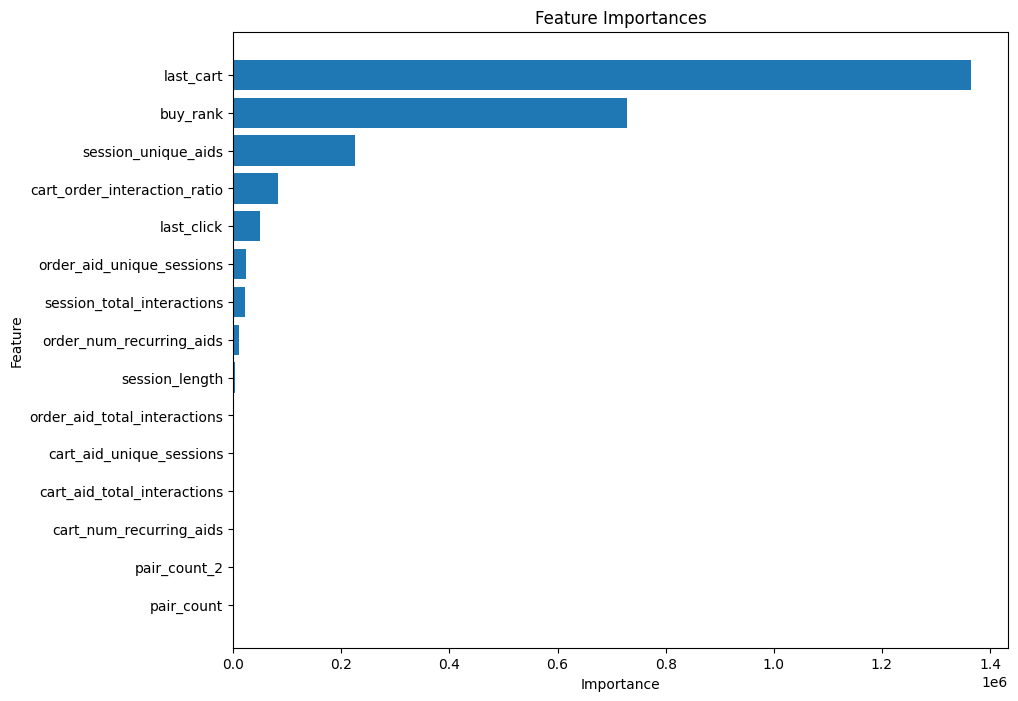

In [ ]:
# Get feature importances
feature_importances = ranker.feature_importances_

# Create list of tuples with feature names and importances
feature_importances_list = list(zip(feature_cols, feature_importances))

# Sort list by importance
sorted_feature_importances_list = sorted(feature_importances_list, key=lambda x: x[1])

# Create list of feature names and importances
feature_names = [x[0] for x in sorted_feature_importances_list]
importances = [x[1] for x in sorted_feature_importances_list]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, importances, align='center')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importances');

Last cart has the highest importance followed by rank according to candidate generation sequence ("buy_rank"). Unique items of each session ("session_unique_aids") is next highest. This is unexpected since I don't expect user features to have high importance.

Cart features besides last carts were low in importance. Covisitation matrix pairs were also low in importance.

In [ ]:
# save model coefficients
ranker.booster_.save_model('/content/drive/MyDrive/0.capstone/deploy/model.txt')

**Prediction**

In [ ]:
test_candidates_features.head()

X_test = test_candidates_features[feature_cols]

In [ ]:
scores = ranker.predict(X_test.to_pandas())

In [ ]:
print(test_candidates_features.shape)
print(scores.shape)

(35835181, 17)
(35835181,)


**Submission**

In [ ]:
reranker_candidates_features = test_candidates_features.with_columns(pl.Series(name='score', values=scores))
reranker_predictions = reranker_candidates_features.sort('session', 'score').reverse().groupby('session').agg([
    pl.col('aid').limit(20).list()
    ]).explode(['aid'])

reranker_predictions.head()

<ipython-input-24-09006a6423a1>:3: DeprecationWarning: `Expr.list` has been renamed; this redirect is temporary, please use `.implode` instead
  pl.col('aid').limit(20).list()


session,aid
i32,list[i32]
14571581,[1100210]
14571580,"[202353, 433425, … 1246483]"
14571579,"[739876, 1750859, … 832213]"
14571578,"[977826, 1671592, … 103172]"
14571577,[1141710]


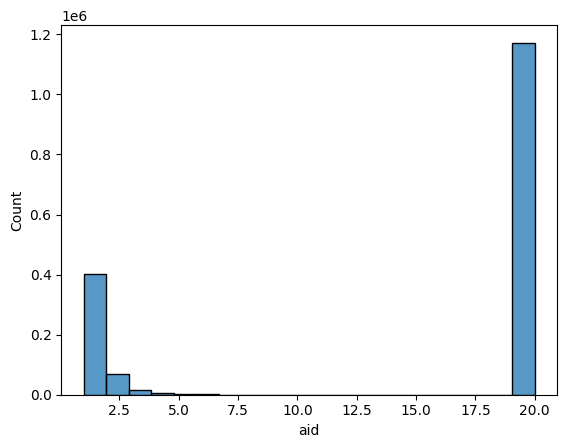

In [ ]:
reranker_predictions_df = reranker_predictions.explode(['aid'])
reranker_predictions_df = reranker_predictions_df.to_pandas()
reranker_predictions_df.head()

sns.histplot(
    data=reranker_predictions_df.groupby('session', as_index=False).agg({'aid' : 'count'}),
    x='aid',
    bins=20
);

In [ ]:
session_types = []
labels = []

for session, preds in zip(reranker_predictions['session'].to_numpy(), reranker_predictions['aid'].to_numpy()):
    l = ' '.join(str(p) for p in preds)
    for session_type in ['clicks', 'carts', 'orders']:
        labels.append(l)
        session_types.append(f'{session}_{session_type}')

In [ ]:
submission = pl.DataFrame({'session_type': session_types, 'labels': labels})
submission.head()

session_type,labels
str,str
"""14571581_click…","""1100210"""
"""14571581_carts…","""1100210"""
"""14571581_order…","""1100210"""
"""14571580_click…","""202353 433425 …"
"""14571580_carts…","""202353 433425 …"


In [ ]:
submission.shape

(5015409, 2)

In [ ]:
submission_template = pd.read_parquet('/content/drive/MyDrive/0.capstone/preprocessed/submission_template.parquet')

In [ ]:
submission = submission.to_pandas()
submission_order = submission[submission['session_type'].str.contains('_orders')]

submission_blank_click = submission_template[submission_template['session_type'].str.contains('_clicks')]
submission_blank_cart = submission_template[submission_template['session_type'].str.contains('_carts')]

orders_submission = pd.concat([submission_order, submission_blank_click, submission_blank_cart])

In [ ]:
orders_submission.to_csv('/content/drive/MyDrive/0.capstone/for_submission/reranker_16_orders.csv', index=False)

**Results**

Kaggle score (Orders only): 0.37132 <br>
Comparatively, rule-based ranker score for Orders only was better at 0.39693.

Including rule-based click and cart scores, the overall score is: 0.55088.

Theoretically, a reranker should perform better than a pure rule-based ranker. However, this did not work possibily due to a few reasons:
- not enough candidates (requires more machine resources to increase)
- not enough features (requires much more experimentation to produce)
- overfitting between train and test data (in hindsight, should have done thorough validation)

Reducing the number of features for this reranker helped to improve the score above 0.37206 due to less overfitting, but not better than the handcrafted ranker score of 0.39693.

Doing cross-validation might help to improve the score and reduce overfitting. However, there was issues with resources when designing the cross-validation for LGBM Ranker.

We recommend using a rule-based ranker for this case as it requires far less steps and produces a better score. For deployment however, we will explore using this LGBM Ranker as the scoring is not far off. As the deployment serves more as a proof of concept, we will also keep all the above features.